You can follow along and play with this notebook by clicking the badge below

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jasongfleischer/UCSD_COGS118A/blob/main/Notebooks/Lecture_14_support_vector_machines.ipynb)

# Support Vector Machines

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.


In [65]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Motivating Support Vector Machines

Let's make a classification task, in which the two classes of points are well separated:

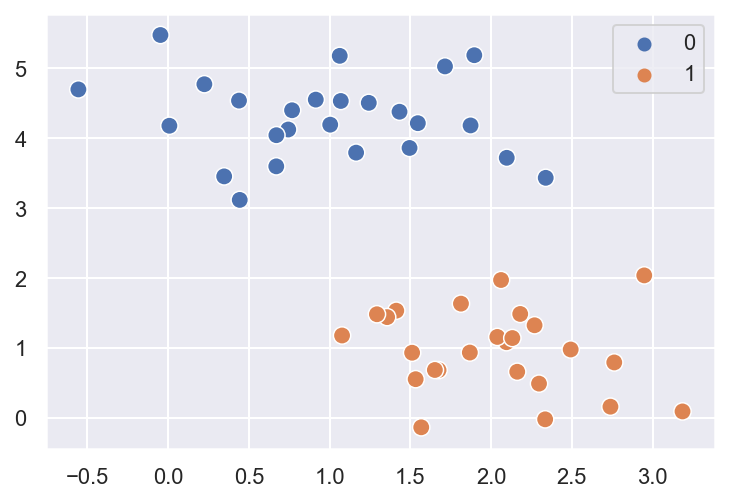

In [66]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
sns.scatterplot(X[:, 0], X[:, 1], hue=y, s=75);


A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
For two dimensional data like that shown here, this is a task we could do by hand.
But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

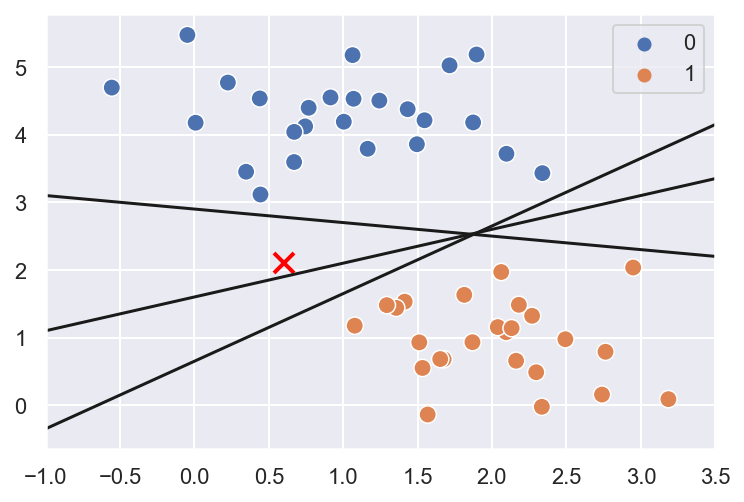

In [67]:
xfit = np.linspace(-1, 3.5)
sns.scatterplot(X[:, 0], X[:, 1], hue=y, s=75);


plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Support Vector Machines: Maximizing the *Margin*

Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.
Here is an example of how this might look:

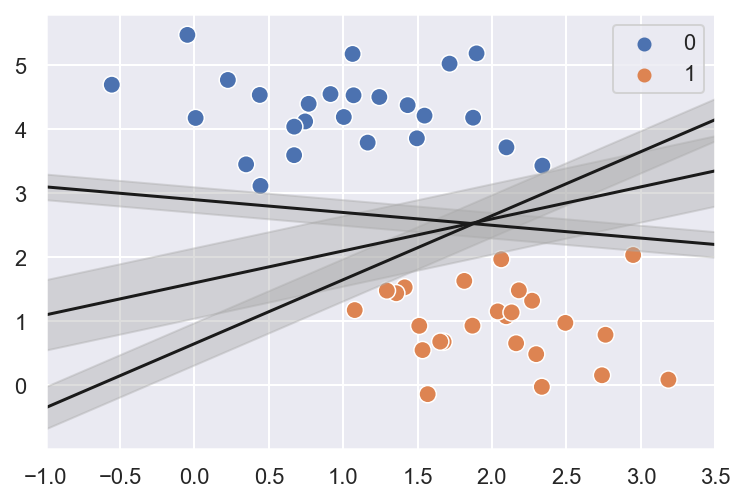

In [68]:
xfit = np.linspace(-1, 3.5)
sns.scatterplot(X[:, 0], X[:, 1], hue=y, s=75);

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of such a *maximum margin* estimator.

### Fitting a support vector machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data.
For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [75]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [73]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=3, facecolors='none', edgecolor='k');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

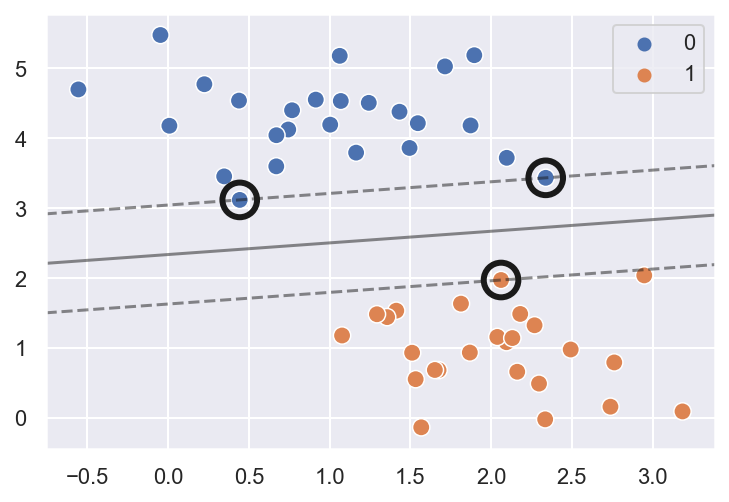

In [77]:
sns.scatterplot(X[:, 0], X[:, 1], hue=y, s=75);

plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure.
These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name.
In Scikit-Learn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier:

In [78]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit!
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

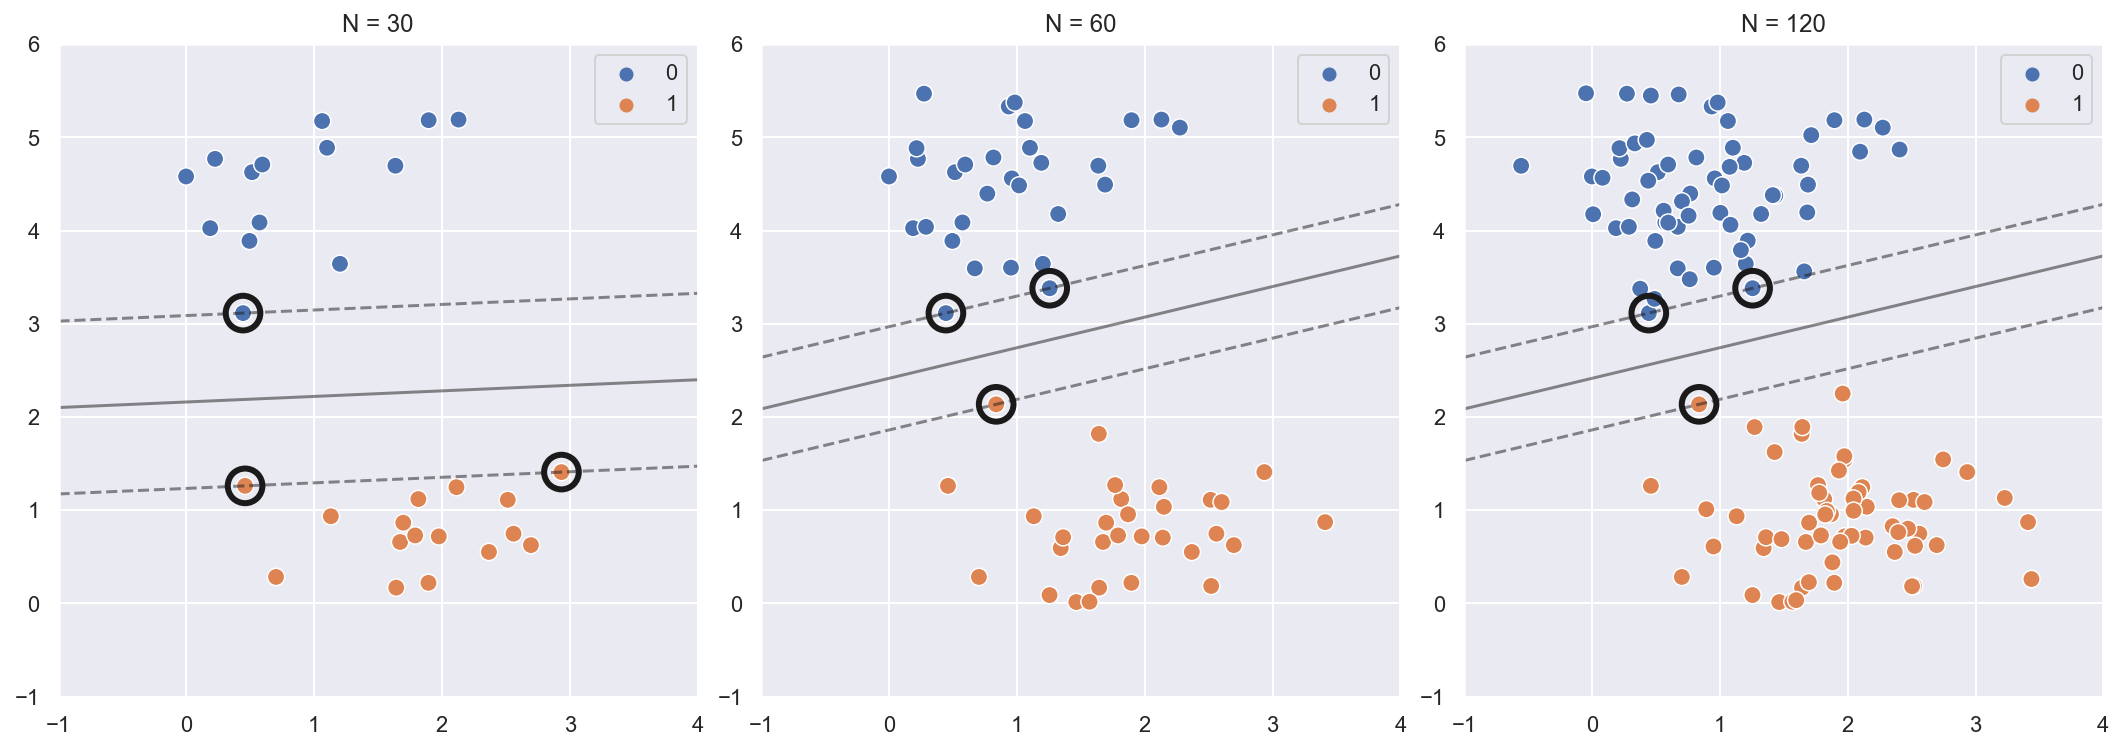

In [79]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    sns.scatterplot(X[:, 0], X[:, 1], hue=y, s=75, ax=ax)
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 3, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [30, 60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for just 10 training points, in the middle we see  60 training points and on the right panel 120 points.  While going from 30 to 60 caused changes, going from 60 to 120 did not becuase the support vectors (the points on the margin line) had not changed.

This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

### Beyond linear boundaries: Kernel SVM

Where SVM becomes extremely powerful is when it is combined with *kernels*.
We have seen a version of kernels before: Remember polynomial features from the regression lectures?  

There we projected our data into higher-dimensional space defined by polynomials functions, and thereby were able to fit for nonlinear relationships with a linear regression.

In SVM models, we can use a version of the same idea.
To motivate the need for kernels, let's look at some data that is not linearly separable:

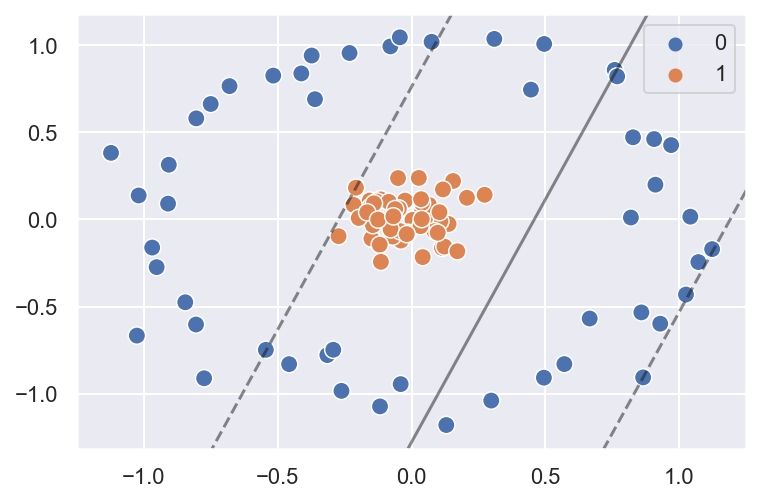

In [80]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

sns.scatterplot(X[:, 0], X[:, 1], hue=y, s=75)
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will *ever* be able to separate this data.

One simple projection we could use would be to compute a *radial basis function* centered on the middle clump:

In [81]:
r = np.exp(-(X ** 2).sum(1))

Adding r as a 3rd dimension gives us this:

<IPython.core.display.Javascript object>


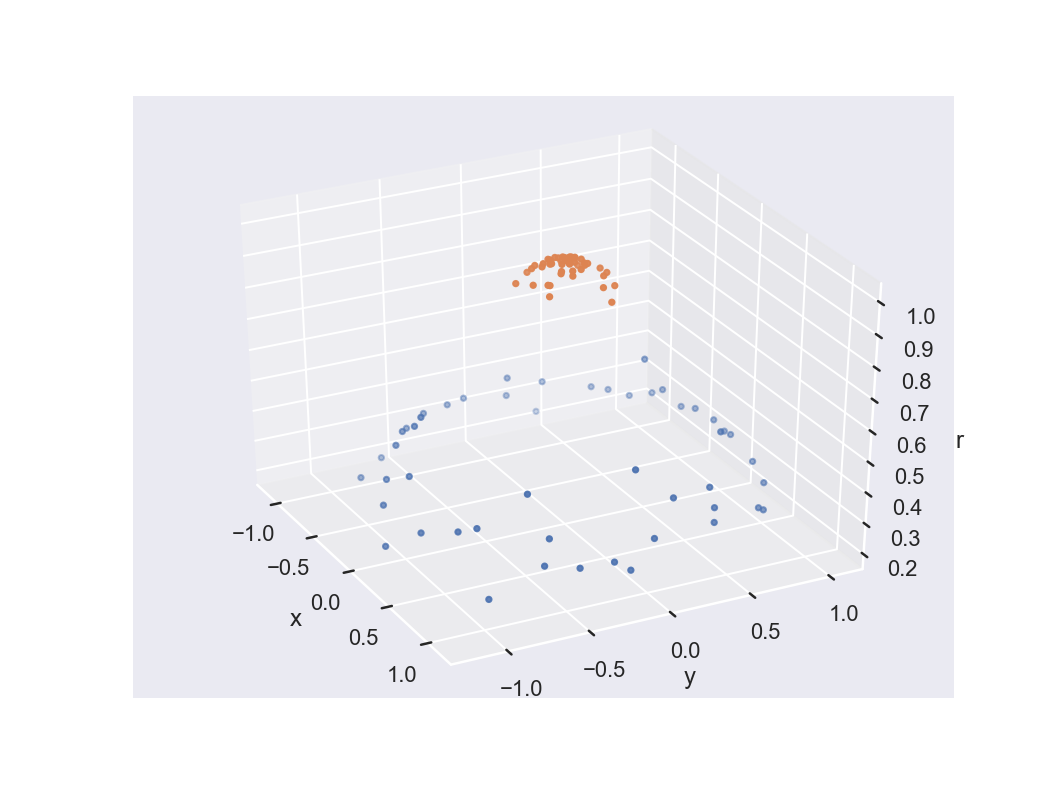

In [82]:
%matplotlib notebook

from mpl_toolkits import mplot3d
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette()[:2])

ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=7, cmap=cmap)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r');


We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, *r*=0.7.

Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.
In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.
This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection!
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter:

In [83]:
%matplotlib inline

In [90]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

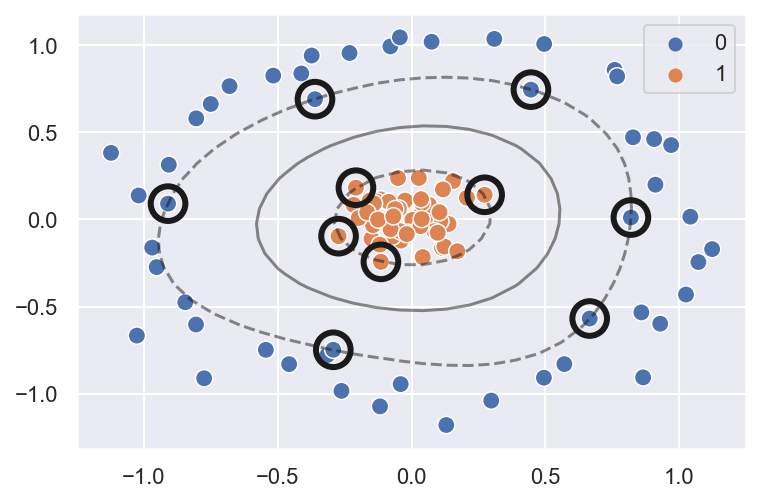

In [91]:
sns.scatterplot(X[:, 0], X[:, 1], hue=y, s=75)
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none', edgecolor='k');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

### Tuning the SVM: Softening Margins

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this:

In [ ]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
sns.scatterplot(X[:, 0], X[:, 1], hue=y, s=75);

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as $C$.
For very large $C$, the margin is hard, and points cannot lie in it.
For smaller $C$, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

In [ ]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    sns.scatterplot(X[:, 0], X[:, 1], hue=y, s=75, ax=axi)
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none', edgecolor='k');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure..  something we will be covering in detail in a  near-future lecture!

## Example: 

In [ ]:
# lets get some 🐧 data to work with
df = sns.load_dataset("penguins")

# plot all pairs of variables against each other to see how the measurements 
# separate species from each other. The diagonal shows for 1 variable only
# how that variable relates to species
sns.pairplot(df, hue="species")

# also lets look at a few of the data points raw so we see what it looks like
df.head()

In [ ]:
df=df.dropna() # get rid of samples where some data is missing

In [ ]:
from sklearn.svm import SVC
#f#rom sklearn.decomposition import RandomizedPCA
#from sklearn.pipeline import make_pipeline

#pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
model = SVC(kernel='rbf', class_weight='balanced')
#model = make_pipeline(pca, svc)

For the sake of testing our classifier output, we will split the data into a training and testing set. The last time we played with the penguin data we were using it for just 2 species using 2 variables.  This time we will let sklearn do all the heavy lifting.  We will try to fit all 4 numeric variables to classify all 3 species.

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']],
                                                df['species'], train_size=0.75, test_size=0.25,
                                                random_state=42)

Finally, we can explore combinations of parameters, to see what they do to SVM perfromance on this training data.

Here you can adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel, what Andrew Ng's lecture denoted as $\sigma$), and play until you get a sense of of what parameters make this model better at fitting the training data

In [ ]:
# try to fit 'C' with values such as [1, 5, 10, 50, 100],
# try to fit 'gamma' with values such as 0.0001, 0.0005, 0.001, 0.005, 0.01]

from sklearn.svm import SVC

model = SVC(kernel='rbf', class_weight='balanced', C=10, gamma=0.001)

model.fit(Xtrain, ytrain)
yfit = model.predict(Xtest)
model


Now with this trained model, we can predict the labels for the test data, which the model has not yet seen:

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit))

Hey look... there's precision and recall... you remember them from the error metrics lecture, right?  But [*which one is which*](https://en.wikipedia.org/wiki/Precision_and_recall)?  F1_score is a combo of precision recall... support is just a column indicating "how many" of each class there is in the test set.

We might also display the confusion matrix between these classes:

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model,Xtest,ytest);
plt.grid(False);


This helps us get a sense of which labels are likely to be confused by the estimator.

Keep on playing with C and gamma and see what you can do with the test set performance here

## Support Vector Machine Summary

We have seen here a brief intuitive introduction to the principals behind support vector machines.
These methods are a powerful classification method for a number of reasons:

- Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter $C$. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the ``probability`` parameter of ``SVC``), but this extra estimation is costly.


*This notebook contains excerpts of text and code from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook). The text from the book was released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code from the book is released under the [MIT license](https://opensource.org/licenses/MIT).* 

*This notebook also contains text and code written by Jason Fleischer.  I'm too tired to think much about it, so I'm happy to release my work under the same licenses*